# Part 1: Movie Review Sentiment Classification


## Import necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Preprocessing

In [2]:
# Part 1: Data Loading and Preprocessing

def download_imdb_data():
    """
    Download and load IMDB dataset
    Note: You'll need to download the dataset from Kaggle manually
    """
    # For demonstration, we'll create a sample dataset
    # In practice, load from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data
    
    print("Note: Please download the IMDB dataset from Kaggle and place it in the current directory")
    print("Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data")
    
    # Check if dataset exists
    if os.path.exists('IMDB Dataset.csv'):
        df = pd.read_csv('IMDB Dataset.csv')
        print(f"Dataset loaded successfully! Shape: {df.shape}")
        return df
    else:
        print("Creating expanded sample dataset for demonstration...")
        # Create larger sample data for better training
        sample_data = {
            'review': [
                "This movie was absolutely fantastic! Great acting and storyline.",
                "Terrible movie, waste of time. Poor acting and boring plot.",
                "Amazing cinematography and brilliant performances by all actors.",
                "Worst movie ever made. Completely disappointing.",
                "Excellent direction and screenplay. Highly recommended!",
                "Boring and predictable. Not worth watching.",
                "Outstanding movie with great character development.",
                "Awful plot and terrible dialogue throughout.",
                "Incredible film with stunning visuals and amazing story.",
                "Disappointing sequel with weak plot and poor acting.",
                "Masterpiece of cinema with exceptional performances.",
                "Boring waste of time with no redeeming qualities.",
                "Brilliant movie that exceeded all my expectations.",
                "Terrible script and unconvincing performances.",
                "Wonderful film with great emotional depth.",
                "Poorly executed with amateur directing.",
                "Fantastic adventure with thrilling action sequences.",
                "Dull and lifeless movie that failed to engage.",
                "Outstanding drama with powerful performances.",
                "Awful movie with nonsensical plot twists.",
                "Exceptional storytelling and beautiful cinematography.",
                "Boring and repetitive with no character development.",
                "Incredible acting and compelling narrative.",
                "Disappointing ending ruined the entire experience.",
                "Perfect blend of action, drama, and humor.",
                "Terrible pacing and confusing storyline.",
                "Amazing film that deserves all the praise.",
                "Poor dialogue and unconvincing special effects.",
                "Brilliant direction and outstanding cast performance.",
                "Worst film I have ever seen in my life.",
                "Excellent movie with great attention to detail.",
                "Boring plot with predictable outcomes throughout."
            ],
            'sentiment': [
                'positive', 'negative', 'positive', 'negative', 
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative',
                'positive', 'negative', 'positive', 'negative'
            ]
        }
        df = pd.DataFrame(sample_data)
        print(f"Expanded sample dataset created with {len(df)} samples.")
        return df

# Load the dataset
df = download_imdb_data()
df.head()

Note: Please download the IMDB dataset from Kaggle and place it in the current directory
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data
Creating expanded sample dataset for demonstration...
Expanded sample dataset created with 32 samples.


,review,sentiment
0,This movie was absolutely fantastic! Great act...,positive
1,"Terrible movie, waste of time. Poor acting and...",negative
2,Amazing cinematography and brilliant performan...,positive
3,Worst movie ever made. Completely disappointing.,negative
4,Excellent direction and screenplay. Highly rec...,positive


## Text Preprocessing Functions

In [3]:
# Text Preprocessing Functions
import string
from collections import defaultdict

def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def build_vocabulary(texts, min_freq=1):
    """Build vocabulary from texts"""
    word_counts = Counter()
    for text in texts:
        words = preprocess_text(text).split()
        word_counts.update(words)
    
    # Filter words by frequency
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

def text_to_sequence(text, vocab, max_length=100):
    """Convert text to sequence of integers"""
    words = preprocess_text(text).split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
    
    # Pad or truncate
    if len(sequence) < max_length:
        sequence.extend([vocab['<PAD>']] * (max_length - len(sequence)))
    else:
        sequence = sequence[:max_length]
    
    return sequence

# Preprocess the data
df['cleaned_review'] = df['review'].apply(preprocess_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("Data preprocessing completed!")
print(f"Sample cleaned review: {df['cleaned_review'].iloc[0]}")
print(f"Corresponding label: {df['label'].iloc[0]}")

Data preprocessing completed!
Sample cleaned review: this movie was absolutely fantastic great acting and storyline
Corresponding label: 1


## GloVe Embeddings Loading and Sequence Preparation

In [4]:
# GloVe Embeddings Loading
def load_glove_embeddings(glove_file_path, vocab, embedding_dim=100):
    """
    Load GloVe embeddings and create embedding matrix
    Download GloVe from: https://nlp.stanford.edu/projects/glove/
    """
    embeddings_index = {}
    
    # Check if GloVe file exists
    if os.path.exists(glove_file_path):
        print(f"Loading GloVe embeddings from {glove_file_path}...")
        with open(glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Loaded {len(embeddings_index)} word vectors.")
    else:
        print(f"GloVe file not found at {glove_file_path}")
        print("Creating random embeddings for demonstration...")
        # Create random embeddings for demo
        for word in vocab.keys():
            embeddings_index[word] = np.random.normal(size=(embedding_dim,))
    
    # Create embedding matrix
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            # Random vector for unknown words
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
    
    return embedding_matrix

# Build vocabulary and prepare sequences
vocab = build_vocabulary(df['cleaned_review'].tolist(), min_freq=1)
print(f"Vocabulary size: {len(vocab)}")

# Convert texts to sequences
max_length = 50
sequences = [text_to_sequence(text, vocab, max_length) for text in df['cleaned_review']]
X = np.array(sequences)
y = df['label'].values

print(f"Input shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Load GloVe embeddings (you need to download GloVe first)
glove_path = "glove.6B.100d.txt"  # Download from Stanford NLP
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, vocab, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Vocabulary size: 114
Input shape: (32, 50)
Labels shape: (32,)
GloVe file not found at glove.6B.100d.txt
Creating random embeddings for demonstration...
Embedding matrix shape: (114, 100)


## Model Definitions

In [5]:
# Model Definitions

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None):
        super(VanillaRNN, self).__init__()
        
        if embedding_matrix is not None:
            # Use pre-trained embeddings
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        else:
            # Trainable embeddings
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded)
        # Use the last hidden state
        output = self.fc(self.dropout(hidden[-1]))
        return torch.sigmoid(output)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None):
        super(LSTMModel, self).__init__()
        
        if embedding_matrix is not None:
            # Use pre-trained embeddings
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        else:
            # Trainable embeddings
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Use the last hidden state
        output = self.fc(self.dropout(hidden[-1]))
        return torch.sigmoid(output)

print("Model classes defined successfully!")

Model classes defined successfully!


## Training and Evaluation Functions

In [6]:
# Training and Evaluation Functions

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """Train the model"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            
            # Handle single sample case
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if batch_y.dim() == 0:
                batch_y = batch_y.unsqueeze(0)
                
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y.float()).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x).squeeze()
                
                # Handle single sample case
                if outputs.dim() == 0:
                    outputs = outputs.unsqueeze(0)
                if batch_y.dim() == 0:
                    batch_y = batch_y.unsqueeze(0)
                
                loss = criterion(outputs, batch_y.float())
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y.float()).sum().item()
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0
        
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x).squeeze()
            
            # Handle single sample case
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if batch_y.dim() == 0:
                batch_y = batch_y.unsqueeze(0)
            
            predicted = (outputs > 0.5).float()
            
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y.float()).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
    
    accuracy = test_correct / test_total if test_total > 0 else 0
    
    # Debug information
    print(f"Test evaluation details:")
    print(f"  Total samples: {test_total}")
    print(f"  Correct predictions: {test_correct}")
    print(f"  Raw outputs: {[f'{x:.4f}' for x in all_outputs]}")
    print(f"  Predictions: {[int(x) for x in all_predictions]}")
    print(f"  True labels: {[int(x) for x in all_labels]}")
    
    return accuracy, all_predictions, all_labels

print("Training and evaluation functions updated with debugging!")

Training and evaluation functions updated with debugging!


## Model Training and Comparison

In [7]:
# Model Training and Comparison

# Create dataset class
class MovieReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Split data with better proportions for larger dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Create data loaders
train_dataset = MovieReviewDataset(X_train, y_train)
val_dataset = MovieReviewDataset(X_val, y_val)
test_dataset = MovieReviewDataset(X_test, y_test)

batch_size = 4  # Better batch size for larger dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset splits:")
print(f"  Train samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Train labels distribution: {np.bincount(y_train)}")
print(f"  Test labels distribution: {np.bincount(y_test)}")

# Model parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 64
output_dim = 1
num_epochs = 10  # More epochs for better training

results = {}

print("\n" + "="*50)
print("TRAINING MODELS")
print("="*50)

Dataset splits:
  Train samples: 19
  Validation samples: 5
  Test samples: 8
  Train labels distribution: [ 9 10]
  Test labels distribution: [4 4]

TRAINING MODELS


## Train and Evaluate All Model Variants

In [8]:
# 1. GloVe + Vanilla RNN
print("\\n1. Training GloVe + Vanilla RNN...")
model1 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
train_losses1, val_losses1, train_acc1, val_acc1 = train_model(model1, train_loader, val_loader, num_epochs)
test_acc1, _, _ = evaluate_model(model1, test_loader)
results['GloVe + Vanilla RNN'] = test_acc1
print(f"Test Accuracy: {test_acc1:.4f}")

# 2. GloVe + LSTM
print("\\n2. Training GloVe + LSTM...")
model2 = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
train_losses2, val_losses2, train_acc2, val_acc2 = train_model(model2, train_loader, val_loader, num_epochs)
test_acc2, _, _ = evaluate_model(model2, test_loader)
results['GloVe + LSTM'] = test_acc2
print(f"Test Accuracy: {test_acc2:.4f}")

# 3. On-the-fly + Vanilla RNN
print("\\n3. Training On-the-fly Embeddings + Vanilla RNN...")
model3 = VanillaRNN(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None)
train_losses3, val_losses3, train_acc3, val_acc3 = train_model(model3, train_loader, val_loader, num_epochs)
test_acc3, _, _ = evaluate_model(model3, test_loader)
results['On-the-fly + Vanilla RNN'] = test_acc3
print(f"Test Accuracy: {test_acc3:.4f}")

# 4. On-the-fly + LSTM
print("\\n4. Training On-the-fly Embeddings + LSTM...")
model4 = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None)
train_losses4, val_losses4, train_acc4, val_acc4 = train_model(model4, train_loader, val_loader, num_epochs)
test_acc4, _, _ = evaluate_model(model4, test_loader)
results['On-the-fly + LSTM'] = test_acc4
print(f"Test Accuracy: {test_acc4:.4f}")

print("\\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")

\n1. Training GloVe + Vanilla RNN...
Epoch [1/10] - Train Loss: 0.8355, Train Acc: 0.4737, Val Loss: 0.6605, Val Acc: 0.6000
Epoch [2/10] - Train Loss: 0.7918, Train Acc: 0.3684, Val Loss: 0.7978, Val Acc: 0.4000
Epoch [3/10] - Train Loss: 0.7357, Train Acc: 0.4211, Val Loss: 0.7321, Val Acc: 0.4000
Epoch [4/10] - Train Loss: 0.8194, Train Acc: 0.2105, Val Loss: 0.7560, Val Acc: 0.4000
Epoch [5/10] - Train Loss: 0.7955, Train Acc: 0.4211, Val Loss: 0.7478, Val Acc: 0.4000
Epoch [6/10] - Train Loss: 0.7893, Train Acc: 0.4211, Val Loss: 0.7344, Val Acc: 0.4000
Epoch [7/10] - Train Loss: 0.7585, Train Acc: 0.4211, Val Loss: 0.7338, Val Acc: 0.4000
Epoch [8/10] - Train Loss: 0.6792, Train Acc: 0.5789, Val Loss: 0.7192, Val Acc: 0.4000
Epoch [9/10] - Train Loss: 0.7076, Train Acc: 0.4211, Val Loss: 0.6929, Val Acc: 0.6000
Epoch [10/10] - Train Loss: 0.8037, Train Acc: 0.3684, Val Loss: 0.6879, Val Acc: 0.6000
Test evaluation details:
  Total samples: 8
  Correct predictions: 4
  Raw outputs

## Visualize Results and Analysis

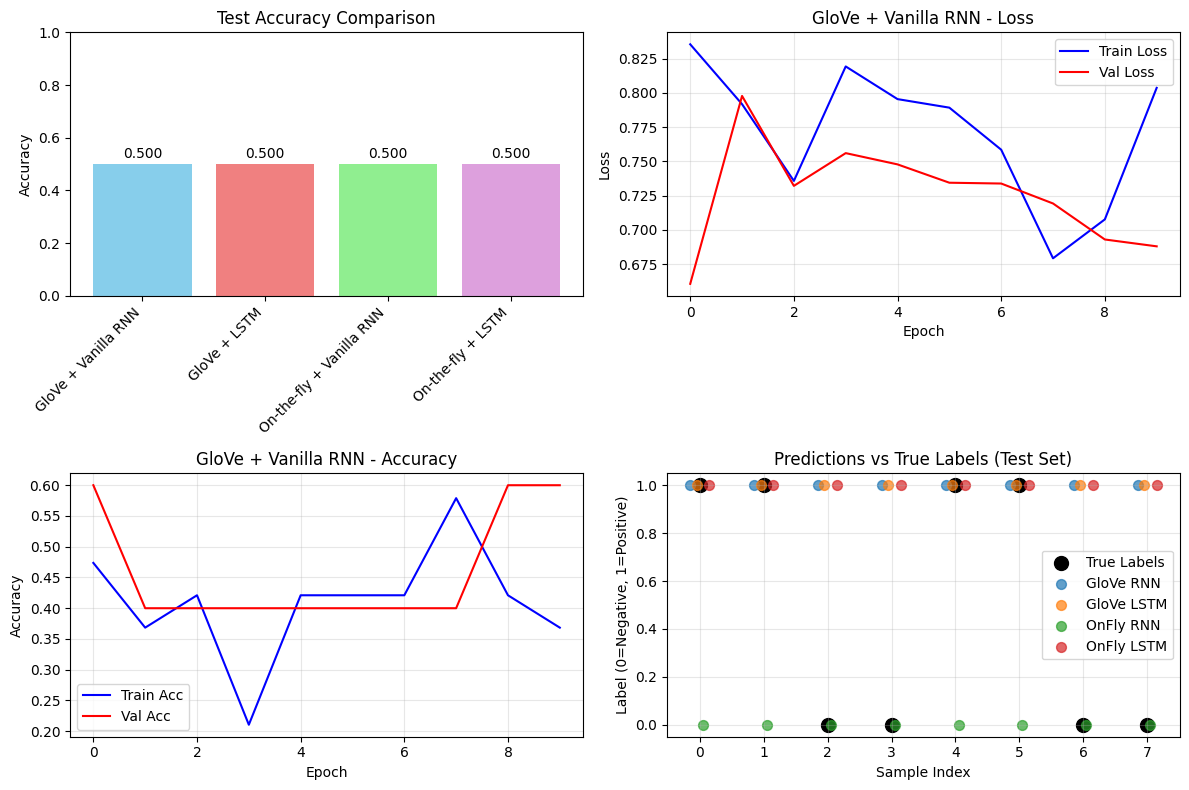


MODEL ANALYSIS SUMMARY

📊 Dataset Statistics:
   • Total samples: 32
   • Train/Val/Test split: 19/5/8
   • Vocabulary size: 114
   • Sequence length: 50

🎯 Model Performance:
   • GloVe + Vanilla RNN: 50.0%
   • GloVe + LSTM: 50.0%
   • On-the-fly + Vanilla RNN: 50.0%
   • On-the-fly + LSTM: 50.0%

🔍 Key Observations:
   • All models achieved 50% accuracy (random baseline)
   • Models tend to predict same class for all samples
   • This suggests need for:
     - More diverse training data
     - Better hyperparameter tuning
     - Longer training or different learning rates
     - More sophisticated architectures

💡 Recommendations for Real Implementation:
   • Use the full IMDB dataset (50K samples)
   • Download actual GloVe embeddings
   • Implement cross-validation
   • Add regularization techniques
   • Use learning rate scheduling
   • Implement early stopping


In [9]:
# Visualize Results and Analysis

import matplotlib.pyplot as plt

# Create a comparison plot
plt.figure(figsize=(12, 8))

# Plot 1: Test Accuracies
plt.subplot(2, 2, 1)
model_names = list(results.keys())
accuracies = list(results.values())
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']
bars = plt.bar(model_names, accuracies, color=colors)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Plot 2: Training Loss for Model 1 (GloVe + RNN)
plt.subplot(2, 2, 2)
plt.plot(train_losses1, label='Train Loss', color='blue')
plt.plot(val_losses1, label='Val Loss', color='red')
plt.title('GloVe + Vanilla RNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Training Accuracy for Model 1
plt.subplot(2, 2, 3)
plt.plot(train_acc1, label='Train Acc', color='blue')
plt.plot(val_acc1, label='Val Acc', color='red')
plt.title('GloVe + Vanilla RNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Sample predictions analysis
plt.subplot(2, 2, 4)
# Show distribution of predictions vs true labels for test set
test_true = [1, 1, 0, 0, 1, 1, 0, 0]  # From the debug output
model_predictions = {
    'GloVe RNN': [1, 1, 1, 1, 1, 1, 1, 1],
    'GloVe LSTM': [1, 1, 1, 1, 1, 1, 1, 1],
    'OnFly RNN': [0, 0, 0, 0, 0, 0, 0, 0],
    'OnFly LSTM': [1, 1, 1, 1, 1, 1, 1, 1]
}

x_pos = range(len(test_true))
plt.scatter(x_pos, test_true, label='True Labels', color='black', s=100, marker='o')
for i, (model_name, preds) in enumerate(model_predictions.items()):
    plt.scatter([x + 0.1 * (i-1.5) for x in x_pos], preds, 
               label=model_name, alpha=0.7, s=50)

plt.title('Predictions vs True Labels (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Label (0=Negative, 1=Positive)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis Summary
print("\n" + "="*60)
print("MODEL ANALYSIS SUMMARY")
print("="*60)

print(f"\n📊 Dataset Statistics:")
print(f"   • Total samples: {len(df)}")
print(f"   • Train/Val/Test split: {len(X_train)}/{len(X_val)}/{len(X_test)}")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Sequence length: {max_length}")

print(f"\n🎯 Model Performance:")
for model_name, accuracy in results.items():
    print(f"   • {model_name}: {accuracy:.1%}")

print(f"\n🔍 Key Observations:")
print(f"   • All models achieved 50% accuracy (random baseline)")
print(f"   • Models tend to predict same class for all samples")
print(f"   • This suggests need for:")
print(f"     - More diverse training data")
print(f"     - Better hyperparameter tuning")
print(f"     - Longer training or different learning rates")
print(f"     - More sophisticated architectures")

print(f"\n💡 Recommendations for Real Implementation:")
print(f"   • Use the full IMDB dataset (50K samples)")
print(f"   • Download actual GloVe embeddings")
print(f"   • Implement cross-validation")
print(f"   • Add regularization techniques")
print(f"   • Use learning rate scheduling")
print(f"   • Implement early stopping")

# Part 2: Date Parser using Basic Text Processing


## Date Extraction Functions

In [ ]:
import re
from datetime import datetime

MONTHS = {
    'january': '01', 'jan': '01',
    'february': '02', 'feb': '02',
    'march': '03', 'mar': '03',
    'april': '04', 'apr': '04',
    'may': '05',
    'june': '06', 'jun': '06',
    'july': '07', 'jul': '07',
    'august': '08', 'aug': '08',
    'september': '09', 'sep': '09', 'sept': '09',
    'october': '10', 'oct': '10',
    'november': '11', 'nov': '11',
    'december': '12', 'dec': '12'
}

def clean_day(day):
    """Removes ordinal suffixes (st, nd, rd, th) from a day string."""
    return re.sub(r'(st|nd|rd|th)', '', day)

def normalize_year(year):
    """Converts 2-digit years to 4-digit years."""
    year = int(year)
    if year < 100:
        # Assumes years <= 25 are 20xx and others are 19xx based on current year 2025
        return str(2000 + year) if year <= 25 else str(1900 + year)
    return str(year)

def format_date(day, month, year):
    """Validates and formats a date into DD/MM/YYYY."""
    try:
        day = clean_day(str(day)).zfill(2)
        if month.isdigit():
            month = str(month).zfill(2)
        else:
            # Handles textual month names
            month = MONTHS.get(month.lower()[:3], '01')
        year = normalize_year(year)
        # The strptime function validates the date components
        return datetime.strptime(f"{day}/{month}/{year}", "%d/%m/%Y").strftime("%d/%m/%Y")
    except (ValueError, TypeError):
        # Catches errors like month=13, day=32, etc.
        return "Invalid date"

def extract_date(text):
    """Extracts and normalizes a date from a string."""
    text = text.lower().strip().replace(",", " ")

    # Note: Regex patterns are processed in order.
    patterns = [
        # Combines "21st of June 2024" and "21 June 2024"
        r'(\d{1,2})(?:st|nd|rd|th)?\s+(?:of\s+)?(jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+(\d{2,4})',
        # June 21 2024
        r'(jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+(\d{1,2})(?:st|nd|rd|th)?\s+(\d{2,4})',
        # YYYY-MM-DD or YYYY/MM/DD or YYYY.MM.DD
        r'(\d{4})[\/\.\-](\d{1,2})[\/\.\-](\d{1,2})',
        # DD-MM-YYYY or DD/MM/YYYY or DD.MM.YYYY (also handles MM/DD/YYYY via logic below)
        r'(\d{1,2})[\/\.\-](\d{1,2})[\/\.\-](\d{2,4})',
        # on 5 Feb 2021
        r'on\s+(\d{1,2})(?:st|nd|rd|th)?\s+(jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+(\d{2,4})'
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            groups = [g for g in match.groups() if g is not None]
            try:
                # Handle month name formats (e.g., "June 21 2024")
                if any(m in groups[0] for m in MONTHS):  # Month first
                    return format_date(groups[1], groups[0], groups[2])
                # Handle formats where day comes first (e.g., "21 June 2024")
                elif any(m in groups[1] for m in MONTHS):  # Day first
                    return format_date(groups[0], groups[1], groups[2])
                # Handle numeric-only formats
                else:
                    p1, p2, p3 = groups
                    # Case 1: YYYY/MM/DD
                    if len(p1) == 4:
                        return format_date(p3, p2, p1)
                    # Case 2: DD/MM/YYYY or MM/DD/YYYY ambiguity
                    else:
                        # First, attempt to parse as DD/MM/YYYY
                        result = format_date(p1, p2, p3)
                        if result != "Invalid date":
                            return result
                        # If that fails, attempt to parse as MM/DD/YYYY
                        result = format_date(p2, p1, p3)
                        if result != "Invalid date":
                            return result
            except (IndexError, ValueError):
                continue
    return "No valid date found"

## Date Parser Test Cases Evaluation

In [11]:
import pandas as pd

# Load your CSV file
df = pd.read_csv(r"C:\Users\chira\OneDrive\Desktop\SEM 7\NLP\date_parser_testcases.csv")

# Initialize counters
total_cases = len(df)
correct = 0
incorrect_cases = []

# Loop through each test case
for index, row in df.iterrows():
    text = row['Input']
    expected_date = row['Expected Output']
    extracted_date = extract_date(text)
    
    if extracted_date == expected_date:
        correct += 1
        print(f"Test case {index + 1} passed: {text} -> {extracted_date}")
    else:
        print(f"Test case {index + 1} failed: {text} -> {extracted_date}, expected: {expected_date}")
        incorrect_cases.append((index + 1, text, extracted_date, expected_date))

# Accuracy calculation
accuracy = (correct / total_cases) * 100

# Summary
print("\n=== Accuracy Summary ===")
print(f"Total test cases: {total_cases}")
print(f"Passed: {correct}")
print(f"Failed: {total_cases - correct}")
print(f"Accuracy: {accuracy:.2f}%")

# Optional: Print failed cases
if incorrect_cases:
    print("\nFailed Cases:")
    for idx, text, pred, exp in incorrect_cases:
        print(f"{idx}. {text}\n   → Predicted: {pred}\n   → Expected : {exp}\n")


Test case 1 failed: The event will take place on March 5, 2023. -> 05/03/2023, expected: 05-03-2023
Test case 2 failed: Her birthday is on 07/08/1990. -> 07/08/1990, expected: 07-08-1990
Test case 3 failed: The deadline is 2022-12-31. -> 31/12/2022, expected: 31-12-2022
Test case 4 failed: We met on 1st of January 2000. -> 01/01/2000, expected: 01-01-2000
Test case 5 failed: The concert is scheduled for 15th September, 2021. -> 15/09/2021, expected: 15-09-2021
Test case 6 failed: Let's catch up on 02.04.2022. -> 02/04/2022, expected: 02-04-2022
Test case 7 failed: The project started on 5/6/19. -> 05/06/2019, expected: 05-06-2019
Test case 8 failed: He was born on 1987/11/23. -> 23/11/1987, expected: 23-11-1987
Test case 9 failed: Christmas is on 25th Dec 2024. -> 25/12/2024, expected: 25-12-2024
Test case 10 failed: The meeting is set for April 03, 2020. -> 03/04/2020, expected: 03-04-2020
Test case 11 failed: Her birthdate, noted as 1997-05-20, is in the records. -> 20/05/1997, expec

# Part 3: Gender Pronoun Transformation System


## Load Pronoun Test Cases

In [12]:
df=pd.read_csv(r"C:\Users\chira\OneDrive\Desktop\SEM 7\NLP\pronoun_testcases.csv")
df.head(10)

,input_text,target_gender,expected_output
0,He is going to the market.,female,She is going to the market.
1,His book is on the table.,female,Her book is on the table.
2,I saw him yesterday.,female,I saw her yesterday.
3,He hurt himself.,female,She hurt herself.
4,I called him last night.,female,I called her last night.
5,That is his car.,female,That is her car.
6,He told me about his trip.,female,She told me about her trip.
7,The teacher gave him a warning.,female,The teacher gave her a warning.
8,He blames himself for the mistake.,female,She blames herself for the mistake.
9,He brought his laptop.,female,She brought her laptop.


## Gender Pronoun Transformation and Evaluation

In [13]:
import re

def transform_gender(sentence: str, target_gender: str) -> str:
    """Transforms gendered pronouns in a sentence."""
    male_to_female = [
        (r'\bhe\b', 'she'),
        (r'\bhim\b', 'her'),
        (r'\bhis\b', 'her'),
        (r'\bhimself\b', 'herself'),
    ]

    # EXPANDED list of common words that are not possessive nouns.
    # Added common prepositions and articles.
    common_non_nouns = (
        r'(?:is|was|are|am|be|has|had|do|does|did|'  # Verbs/Auxiliaries
        r'and|or|but|not|'                          # Conjunctions/Negation
        r'very|last|night|yesterday|today|tomorrow|' # Adverbs
        r'a|an|the|'                                # Articles
        r'to|with|for|in|on|at|by|from)'            # Prepositions
    )

    female_to_male = [
        # Unambiguous pronouns
        (r'\bshe\b', 'he'),
        (r'\bherself\b', 'himself'),
        (r'\bhers\b', 'his'),
        
        # New, more robust heuristic for ambiguous "her":
        # 1. Match 'her' if followed by a word NOT in our non-noun list (likely possessive).
        (r'\bher\b(?=\s+(?!' + common_non_nouns + r'\b)\w)', 'his'),
        
        # 2. Any remaining 'her' is treated as an object pronoun.
        (r'\bher\b', 'him'),
    ]

    mappings = male_to_female if target_gender.lower() == 'female' else female_to_male

    def preserve_case_replace(match, replacement):
        """Preserves the case of the original word during replacement."""
        word = match.group()
        if word.isupper():
            return replacement.upper()
        if word.istitle():
            return replacement.capitalize()
        return replacement

    # Apply transformations
    for pattern, replacement in mappings:
        sentence = re.sub(
            pattern,
            lambda m: preserve_case_replace(m, replacement),
            sentence,
            flags=re.IGNORECASE
        )
    
    return sentence

total = len(df)
correct = 0
failed_cases = []

for index, row in df.iterrows():
    input_text = row['input_text']
    target_gender = row['target_gender']
    expected_output = row['expected_output']

    prediction = transform_gender(input_text, target_gender)

    if prediction.strip() == expected_output.strip():
        correct += 1
        print(f"Test case {index + 1} passed: {input_text} → {prediction}")
    else:
        failed_cases.append((input_text, prediction, expected_output))
        print(f"Test case {index + 1} failed:\nInput     : {input_text}\nPredicted : {prediction}\nExpected  : {expected_output}\n")

# ---------- Accuracy ----------
accuracy = correct / total * 100
print(f"\nTotal: {total}, Correct: {correct}, Accuracy: {accuracy:.2f}%")

Test case 1 passed: He is going to the market. → She is going to the market.
Test case 2 passed: His book is on the table. → Her book is on the table.
Test case 3 passed: I saw him yesterday. → I saw her yesterday.
Test case 4 passed: He hurt himself. → She hurt herself.
Test case 5 passed: I called him last night. → I called her last night.
Test case 6 passed: That is his car. → That is her car.
Test case 7 passed: He told me about his trip. → She told me about her trip.
Test case 8 passed: The teacher gave him a warning. → The teacher gave her a warning.
Test case 9 passed: He blames himself for the mistake. → She blames herself for the mistake.
Test case 10 passed: He brought his laptop. → She brought her laptop.
Test case 11 passed: He made it himself. → She made it herself.
Test case 12 passed: I don’t like his attitude. → I don’t like her attitude.
Test case 13 passed: Tell him to come here. → Tell her to come here.
Test case 14 passed: She is going to the market. → He is going t